In [2]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
import random as rng
from matplotlib import pyplot as plt
import pandas as pd

In [63]:
src = cv.imread('./data/pic_test_2.jpg')
image = src.copy()

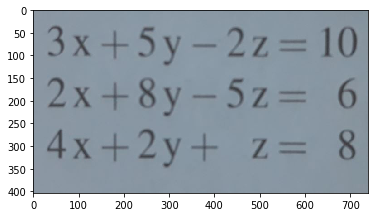

In [64]:
plt.imshow(image)
plt.show()

# Transform and clean image

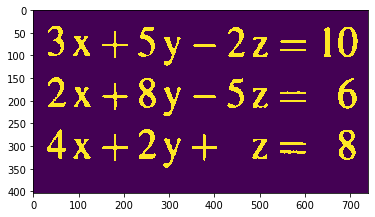

In [65]:
#convert to grayscale for thresholding and then to binary image
image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
ret, image_threshed = cv.threshold(image_gray, 127, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.imshow(image_threshed)
plt.show()

clean image from small contours

In [66]:
#find the contours
image_threshed_copy = image_threshed.copy()
contours,hierarchy = cv.findContours(image_threshed_copy,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)


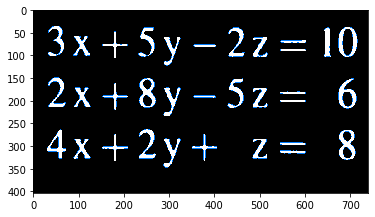

In [67]:
image_all_contours = image_threshed.copy()
image_all_contours = np.expand_dims(image_all_contours, axis=2).repeat(3, axis=2) 
for k, _ in enumerate(contours):
    image_all_contours = cv.drawContours(image_all_contours, contours, k, (0, 125, 255), 1)
plt.imshow(image_all_contours)
plt.show()

In [68]:
##TODO Dynamic threshold via percentile o.ä.

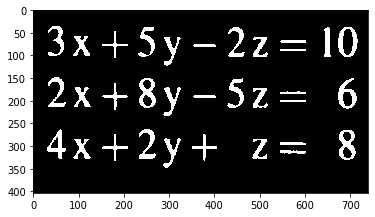

In [69]:
#remove contours with a small area
image_small_contours = image_threshed.copy()
cont_thresh = 5

image_small_contours = np.expand_dims(image_small_contours, axis=2).repeat(3, axis=2) 
for k, contour in enumerate(contours):
        if(cv.contourArea(contour)**2 < cont_thresh):
            image_small_contours = cv.drawContours(image_small_contours, contours, k, (0, 0, 255), 5)
plt.imshow(image_small_contours)
plt.show()

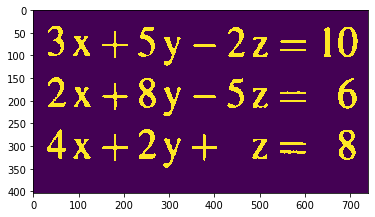

In [171]:
#create prefilled mask
mask = 255 * np.ones(image_threshed.shape[:2], dtype="uint8")

#add the unwanted contours
for c in contours:
    if( cv.contourArea(c)**2 < cont_thresh):
        cv.drawContours(mask, [c], -1, 0, -1)
  
#apply the mask
image_cleaned = cv.bitwise_and(image_threshed, image_threshed, mask=mask)
plt.imshow(image_cleaned)
plt.show()

Verstärke Objekte

In [172]:
image_transformed_final = image_cleaned

# Find the lines of the linear equation system?

borders found for dimension 0 (0: vertical borders, 1 : horizontal borders)
2 borders were found
[(30, 735)]


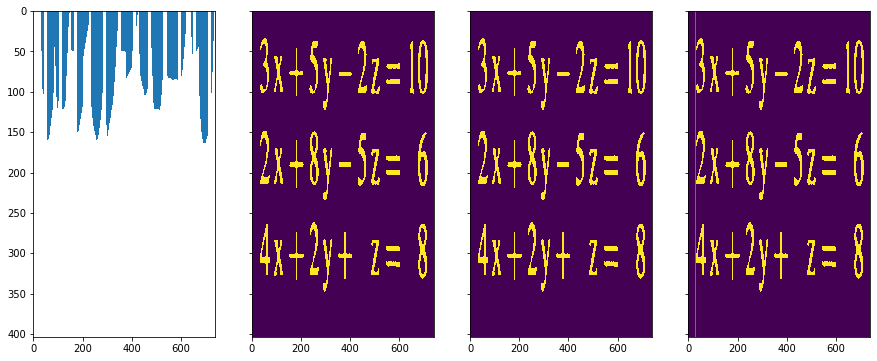

borders found for dimension 1 (0: vertical borders, 1 : horizontal borders)
6 borders were found
[(34, 124), (148, 236), (262, 349)]


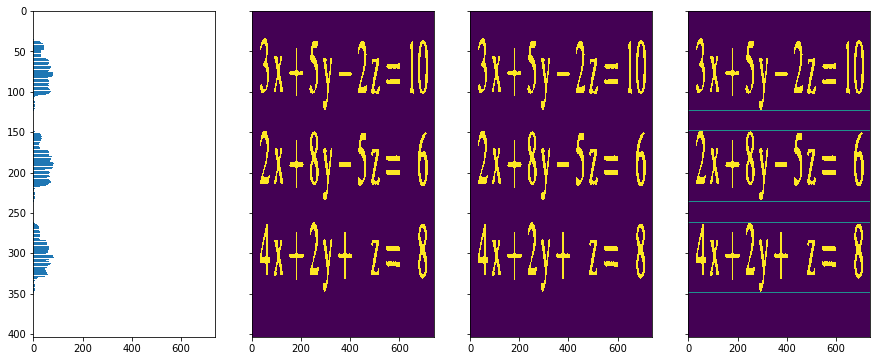

In [173]:
def find_borders(image, dimension = 0, threshold = 1, dilation = 0):

    image_local = image.copy()
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
    image_dilated = cv.dilate(image_local,kernel,iterations = dilation)
    
    hist = cv.reduce(image_dilated,dimension, cv.REDUCE_AVG).reshape(-1)
    
    borders_0 = [i for i in range(len(hist)-1)  if hist[i] <= threshold and hist[i+1] > threshold]
    borders_1 = [i for i in range(len(hist)-1)  if hist[i] >= threshold and hist[i+1] < threshold]
    
    if dimension == 0 and len(borders_0) > 1:
        borders_0 = [borders_0[0]]
        borders_1 = [borders_1[-1]]
        
    
    print(f"borders found for dimension {dimension} (0: vertical borders, 1 : horizontal borders)")
    print(f"{len(borders_0) + len(borders_1)} borders were found")
    print(list(zip(borders_0,borders_1)))
    assert len(borders_0) == len(borders_1), 'sections could not be found'
    
    #plotting    
    fig, axes = plt.subplots(1,4, sharey = True, sharex = True, figsize=(15,6))
    if dimension > 0:
        axes[0].barh(range(len(hist)), hist)
    else:
        axes[0].bar(range(len(hist)), hist)
    
    axes[1].imshow(image_local, aspect = "auto")
    axes[2].imshow(image_local, aspect = "auto")
    
    borders_all = borders_0 + borders_1
    image_borders = image.copy()
    for border in borders_all:
        if dimension > 0:
            image_borders[border,:] = 128
        else:
            image_borders[:,border] = 128
            image_borders[:,border+1] = 128

    axes[3].imshow(image_borders, aspect = "auto")
    plt.show()
    
    return list(zip(borders_0,borders_1))

#test
borders_x = find_borders(image_transformed_final, dimension = 0, threshold = 15, dilation = 20) 
borders_y = find_borders(image_transformed_final, dimension = 1, threshold = 2, dilation = 2)     

Now extract upper and lower horizontal borders. An upper border is a line (one value in histogram) where the value is lower than a predefined threshold `threshold` and the next line has a value > `threshold`

first approach: square section so set same left and right boundary for all lines

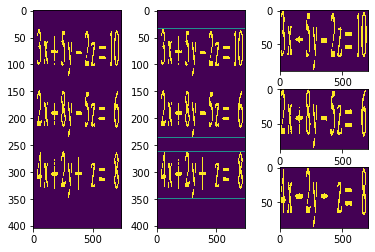

In [174]:
def extract_sections(image, borders_x, borders_y):
    """
    returns: list of section coordinates as tuples (y1, y2, x1, x2)
    """
    image_borders = image.copy()
    x1, x2 = borders_x[0]
    image_borders[:, x1] = 128
    image_borders[:, x2] = 128
    
    sections = []
    for borders in borders_y:
        y1, y2 = borders
        sections.append(image[y1:y2,x1:x2])
        image_borders[y1,:] = 128
        image_borders[y2,:] = 128

    #plot
    grid = plt.GridSpec(len(borders_y), 3, wspace=0.4, hspace=0.3)
    plt.subplot(grid[:len(borders_y), 0])
    plt.imshow(image, aspect = "auto")
    plt.subplot(grid[:len(borders_y), 1])
    plt.imshow(image_borders, aspect = "auto")
    for i in range(len(borders_y)):
        plt.subplot(grid[i, 2])
        plt.imshow(sections[i], aspect = "auto")

    plt.show()
    
    return sections

sections = extract_sections(image_transformed_final, borders_x, borders_y)

# Extract figures for each equation

Similar to removing small fragments we find the single figures via openCVs find contours feature.

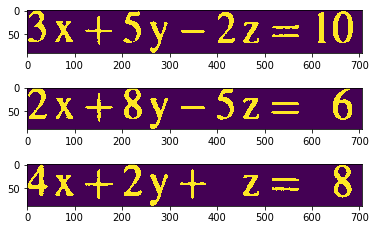

In [175]:
fig, axes = plt.subplots(len(sections),1)
for i, section in enumerate(sections):
    axes[i].imshow(section)
plt.show()

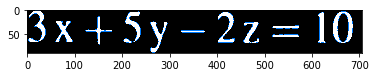

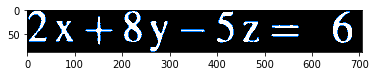

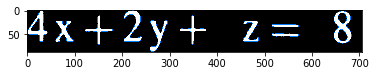

In [176]:
#find the contours
def plot_contours(image):
    """"""
    contours,hierarchy = cv.findContours(image,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    image_all_contours = image.copy()
    image_all_contours = np.expand_dims(image_all_contours, axis=2).repeat(3, axis=2) 
    for k, _ in enumerate(contours):
        image_all_contours = cv.drawContours(image_all_contours, contours, k, (0, 125, 255), 1)
    plt.imshow(image_all_contours)
    plt.show()
    
    return


for i, section in enumerate(sections):
    plot_contours(section)
    

okay, there is a problem with e.g. the plus sign, use dilution to get only a single area that can be foudn via contours, then applay those contour coordinates on the original image pre dilution

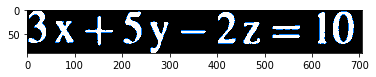

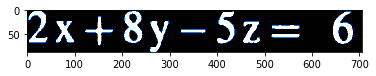

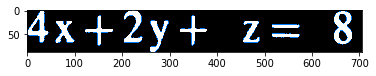

In [177]:
#dilation
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))

for i, section in enumerate(sections):
    image_dilation = cv.dilate(section,kernel,iterations = 2)
    plot_contours(image_dilation)

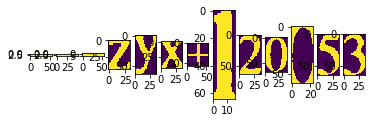

In [178]:
def plot_contours(image, n=0):
    """
    image: 2D array
    n: int
    """
    
    contours,hierarchy = cv.findContours(image,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    #print(hierarchy)
    if n == 0:
        n = len(contours)
    fig, axes = plt.subplots(1,n)
    
    for i in range(n):
        contour = contours[i]

        x_coords = [coord[0][0] for coord in contour]
        y_coords = [coord[0][1] for coord in contour]
       
        increase = 0
        #TODO check if <0 or größer Bild y
        x1 = min(x_coords) - increase
        x2 = max(x_coords) + increase
        y1 = min(y_coords) - increase
        y2 = max(y_coords) + increase

        image_contour = image[y1:y2,x1:x2]
        axes[i].imshow(image_contour)
        
    plt.show()

plot_contours(sections[0])    

In [179]:
#TODO drop small contours


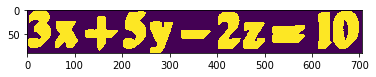

11 figures found


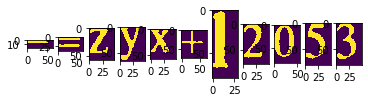

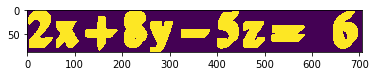

10 figures found


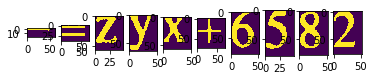

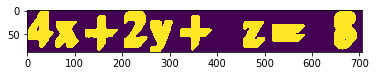

9 figures found


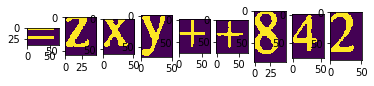

In [180]:
def extract_figures(image, dila_iterations=1, pixel_increase = 1, plot = False):
    """
    returns: list of 2D image matrices sorted by their horizontal position in the image
    """
    
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
    image_dilation = cv.dilate(image,kernel,iterations = dila_iterations)
    #cv.RETR_EXTERNAL, only parents, all childs are discarded
    contours,hierarchy = cv.findContours(image_dilation,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    
    plt.imshow(image_dilation)
    plt.show()
    
    images_figures = []
    images_coords = []
    
    
    image_height, image_width  = image.shape
    
    for i in range(len(contours)):
        contour = contours[i]

        x_coords = [coord[0][0] for coord in contour]
        y_coords = [coord[0][1] for coord in contour]
        
        x1 = max(min(x_coords) - pixel_increase, 0)
        x2 = min(max(x_coords) + pixel_increase, image_width)
        y1 = max(min(y_coords) - pixel_increase, 0)
        y2 = min(max(y_coords) + pixel_increase, image_height)
        
        
        images_figures.append(image[y1:y2,x1:x2])
        images_coords.append([x1,x2,y1,y2])
        
        #figures.append({'coords' : [x1,x2,y1,y2], 'image': image[y1:y2,x1:x2]})
    
    print(f"{len(images_figures)} figures found")
    
    #check if figures overlap -> decrease pixel increase or dilation iterations
    #all_x_coords = [figure['coords'][0:2] for figure in figures]
    
    #print (all_x_coords)
    
    #TODO assert if overlaps
        
    
    #sort
    x1s = [coord[0] for coord in images_coords]
    images_figures_sorted = [image for _, image in (zip(x1s,images_figures))]
    
    
    if plot:
        fig, axes = plt.subplots(1,len(images_figures_sorted))
        for i, figure  in enumerate(images_figures_sorted):
            axes[i].imshow(figure)
            
        plt.show()
        
    return images_figures_sorted

images_figures_sorted = extract_figures(sections[0],12,1, plot = True)
images_figures_sorted = extract_figures(sections[1],12,1, plot = True)
images_figures_sorted = extract_figures(sections[2],12,1, plot = True)

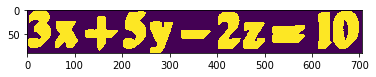

11 figures found


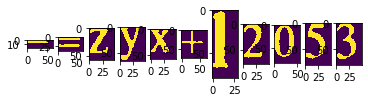

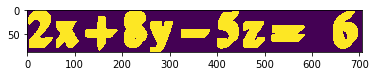

10 figures found


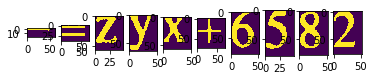

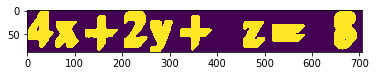

9 figures found


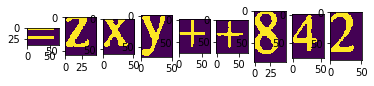

In [181]:
images = []
positions = []
lines = []
for (i, section) in enumerate(sections):
    images_figures_sorted = extract_figures(section,12,1, plot = True)
    for (j,one_image) in enumerate(images_figures_sorted):
        positions.append(j)
        lines.append(i)
        images.append(one_image)
        

In [182]:
figures_df = pd.DataFrame( {'line' : lines, 'position' : positions, 'image' : images })
figures_df.head()

,line,position,image
0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Preprocess figure images for processign with Neural Network

In [183]:
#MNIST: The original black and white (bilevel) images from NIST were size normalized to 
#fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain 
#grey levels as a result of the anti-aliasing technique used by the normalization algorithm. 
#the images were centered in a 28x28 image by computing the center of mass of the pixels,
#and translating the  image so as to position this point at the center of the 28x28 field.

#Kaggle handwritten images: 45x45
#both binary
# -> extracted figure images must be resized to 28x28
#with center of mass of pixels within 28x28 preserving original aspect ratio


figures_df_orig = figures_df.copy()



[0]
[6]
delete rows range(0, 0)
delete cols range(0, 0)


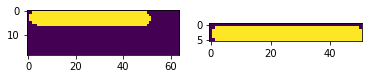

In [184]:
#center of image, size: 20x20

#remove all black lines
def remove_black_rowscols(image):
    
    image_orig = image.copy()

    #gather to cut rows/cols

    
    
    #for row_i in range(image.shape[0]):
        
    threshold = 2
    row_0 = [i for i in range(image.shape[0]-1)  if np.sum(image[i, :]) <= threshold and np.sum(image[i+1, :]) > threshold]
    row_1 = [i for i in range(image.shape[0]-1)  if np.sum(image[i, :]) >= threshold and np.sum(image[i+1, :]) < threshold]
    
    print(row_0)
    print(row_1)
    
    if row_0:
        row_0 = min(row_0)
        print(f"delete rows {range(0, row_0)}" )
        image = np.delete(image,range(0, row_0),0)
    
        
    if row_1:
        row_1 = max(row_1)
        image = np.delete(image,range(row_1,image.shape[0]),0)
        
    col_0 = [i for i in range(image.shape[1]-1)  if np.sum(image[:, i]) <= threshold and np.sum(image[:, i + 1]) > threshold]
    col_1 = [i for i in range(image.shape[1]-1)  if np.sum(image[:, i]) >= threshold and np.sum(image[:, i + 1]) < threshold]
    
    
    if col_0:
        col_0 = min(col_0)
        print(f"delete cols {range(0, col_0)}" )
        image = np.delete(image, range(0, col_0), 1)
    
        
    if col_1:
        col_1 = max(col_1)
        image = np.delete(image, range(col_1, image.shape[1]), 1)
        
    
    
   

    
    #if dimension == 0 and len(borders_0) > 1:
    #    borders_0 = [borders_0[0]]
    #    borders_1 = [borders_1[-1]]
        
        
        
        
        
        
    #    for col_i in range(image.shape[1]):
    #        if (np.sum(image[row_i,:]) == 0) and (np.sum(image[:,col_i]) == 0):
    #            to_cut_rows.append(row_i)
    #            to_cut_cols.append(col_i)
          
    
    #t_cut_rows = list(set(to_cut_rows))
    #t_cut_cols = list(set(to_cut_cols))
    #first_filled_row = 
    #for row_i in range(image.shape[0]):
    #    if np.sum(image[row_i,:]) == 0:
    #        to_cut_rows.append(row_i)
    #        
    #for col_i in range(image.shape[1]):
    #    if np.sum(image[:,col_i]) == 0:
    #        to_cut_cols.append(col_i)
    
    #cut
    #image = np.delete(image,to_cut_rows,0)
    #image = np.delete(image,to_cut_cols,1)
    
    #print(f"rows to cut: {to_cut_rows}")
    #print(f"cols to cut: {to_cut_cols}")
        
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(image_orig)
    axes[1].imshow(image)
    plt.show()
    
    return image

#test
_ = remove_black_rowscols(figures_df.loc[0,'image'])

[0]
[6]
delete rows range(0, 0)
delete cols range(0, 0)


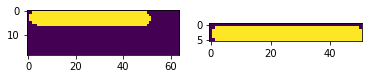

[0, 19]
[7, 25]
delete rows range(0, 0)
delete cols range(0, 0)


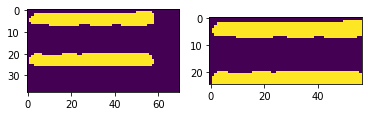

[0]
[45]
delete rows range(0, 0)
delete cols range(0, 0)


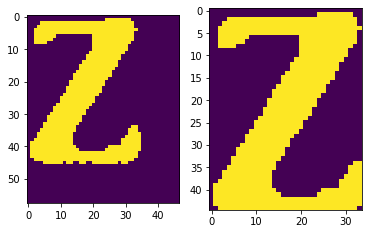

[0]
[65]
delete rows range(0, 0)
delete cols range(0, 0)


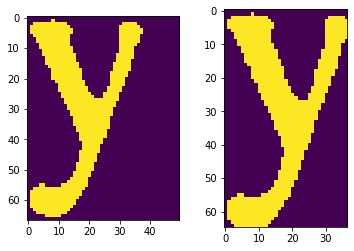

[0]
[45]
delete rows range(0, 0)
delete cols range(0, 0)


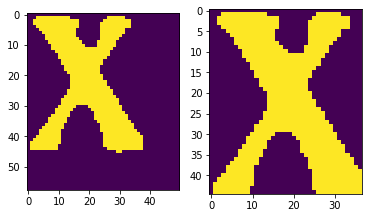

[0]
[61]
delete rows range(0, 0)
delete cols range(0, 0)


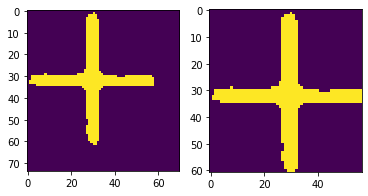

[0]
[66]
delete rows range(0, 0)
delete cols range(0, 0)


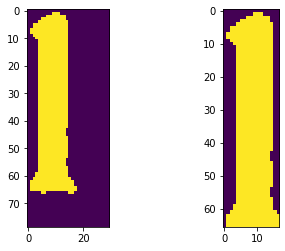

[0]
[66]
delete rows range(0, 0)
delete cols range(0, 0)


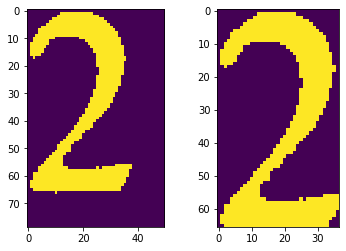

[0]
[68]
delete rows range(0, 0)
delete cols range(0, 0)


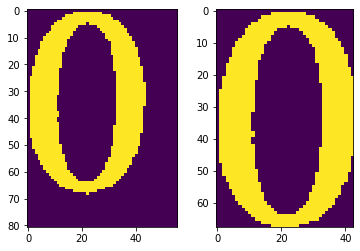

[0]
[67]
delete rows range(0, 0)
delete cols range(0, 0)


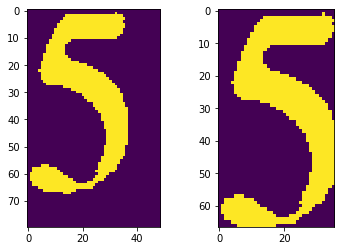

[0]
[67]
delete rows range(0, 0)
delete cols range(0, 0)


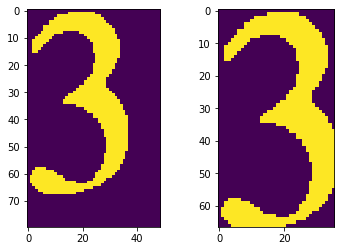

[0]
[7]
delete rows range(0, 0)
delete cols range(0, 0)


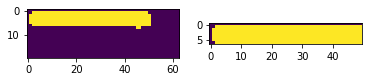

[0, 19]
[7, 25]
delete rows range(0, 0)
delete cols range(0, 0)


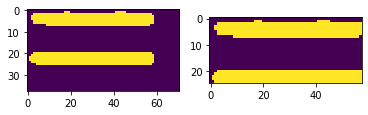

[0]
[44]
delete rows range(0, 0)
delete cols range(0, 0)


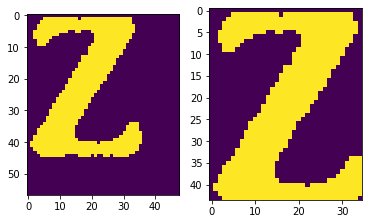

[0]
[64]
delete rows range(0, 0)
delete cols range(0, 0)


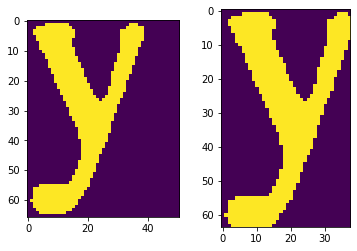

[0]
[44]
delete rows range(0, 0)
delete cols range(0, 0)


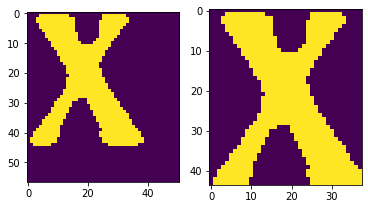

[0]
[60]
delete rows range(0, 0)
delete cols range(0, 0)


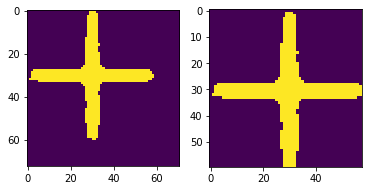

[0]
[67]
delete rows range(0, 0)
delete cols range(0, 0)


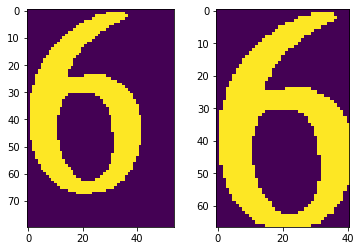

[0]
[66]
delete rows range(0, 0)
delete cols range(0, 0)


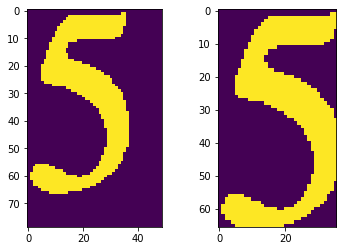

[0]
[66]
delete rows range(0, 0)
delete cols range(0, 0)


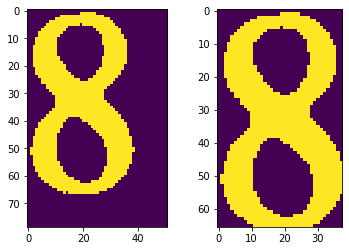

[0]
[66]
delete rows range(0, 0)
delete cols range(0, 0)


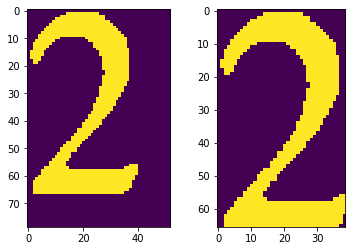

[0, 18]
[6, 25]
delete rows range(0, 0)
delete cols range(0, 0)


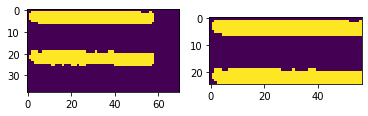

[0]
[44]
delete rows range(0, 0)
delete cols range(0, 0)


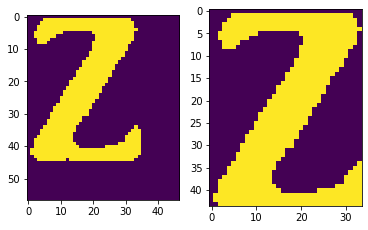

[0]
[45]
delete rows range(0, 0)
delete cols range(0, 0)


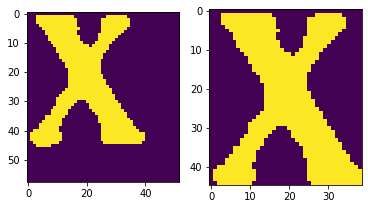

[0]
[65]
delete rows range(0, 0)
delete cols range(0, 0)


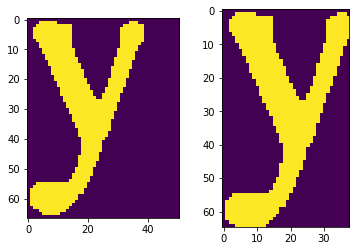

[0]
[61]
delete rows range(0, 0)
delete cols range(0, 0)


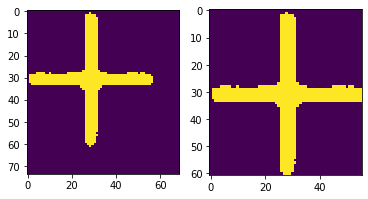

[0]
[61]
delete rows range(0, 0)
delete cols range(0, 0)


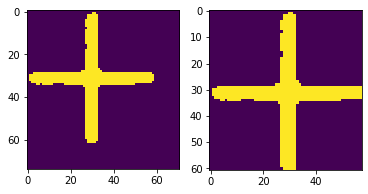

[0]
[68]
delete rows range(0, 0)
delete cols range(0, 0)


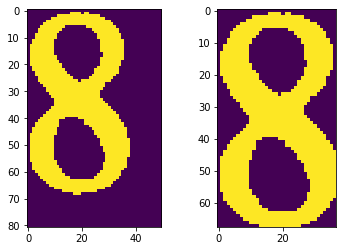

[0]
[65]
delete rows range(0, 0)
delete cols range(0, 0)


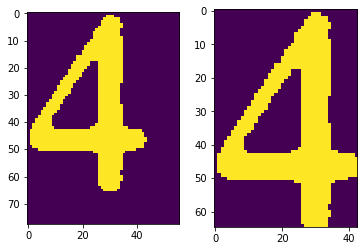

[]
[65]
delete cols range(0, 0)


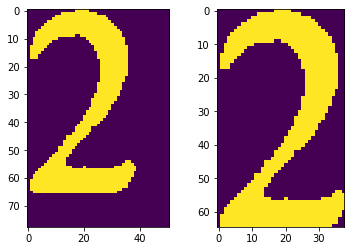

In [185]:
figures_df['image'] = figures_df['image'].apply(remove_black_rowscols)

now transform to 20x20 center of 28x28 binary image

wider
8.5
3
28


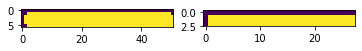

wider
2.28
12
28


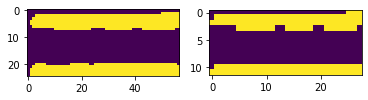

0.7555555555555555
28
21


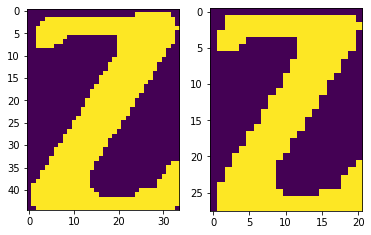

0.5692307692307692
28
15


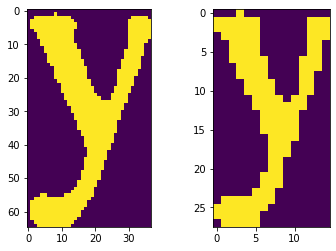

0.8222222222222222
28
23


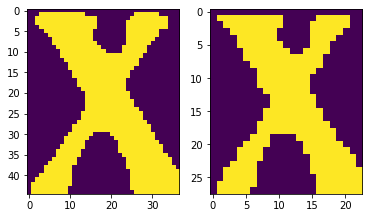

0.9344262295081968
28
26


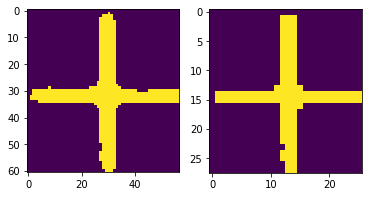

0.25757575757575757
28
7


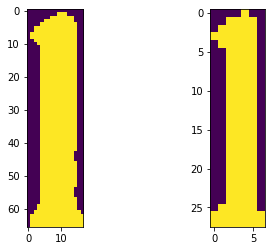

0.5606060606060606
28
15


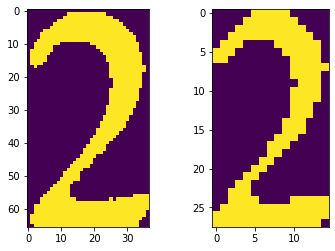

0.6323529411764706
28
17


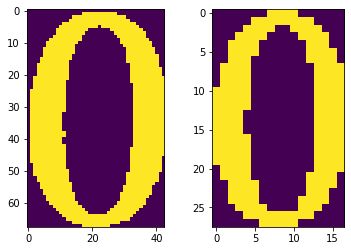

0.5373134328358209
28
15


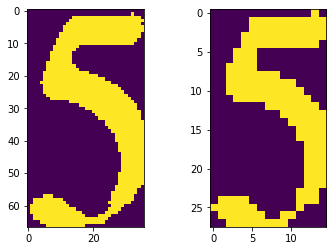

0.5373134328358209
28
15


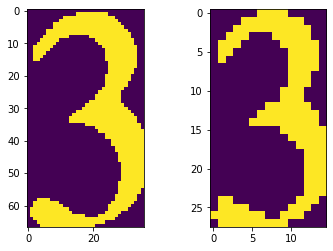

wider
7.142857142857143
3
28


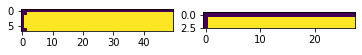

wider
2.32
12
28


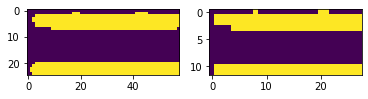

0.7954545454545454
28
22


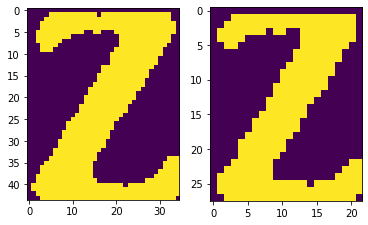

0.59375
28
16


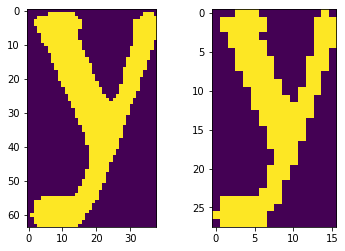

0.8636363636363636
28
24


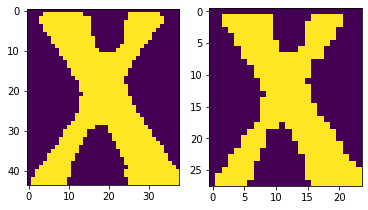

0.9666666666666667
28
27


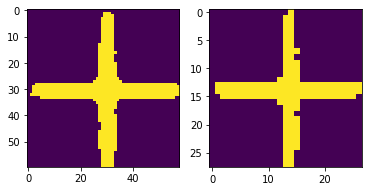

0.6119402985074627
28
17


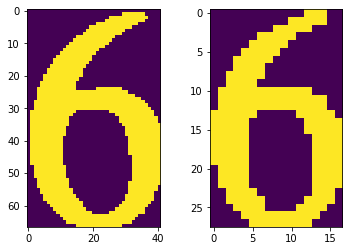

0.5454545454545454
28
15


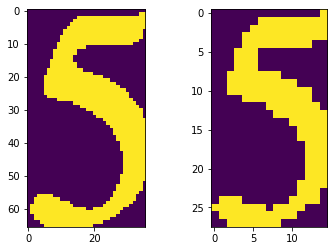

0.5757575757575758
28
16


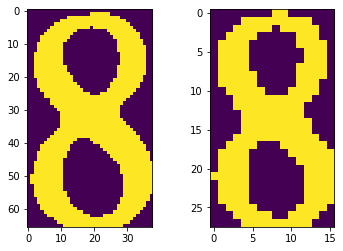

0.5909090909090909
28
16


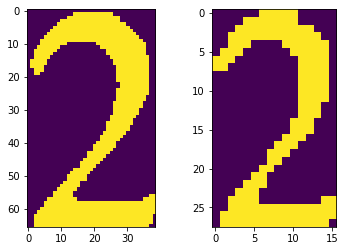

wider
2.28
12
28


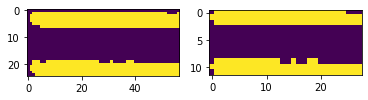

0.7727272727272727
28
21


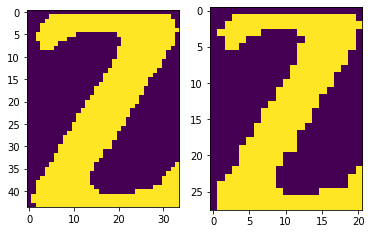

0.8666666666666667
28
24


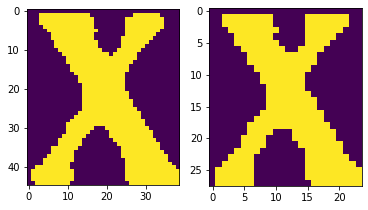

0.5846153846153846
28
16


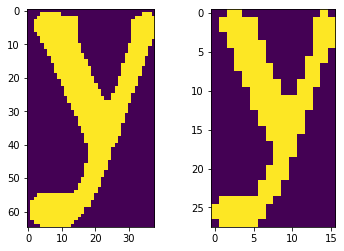

0.9180327868852459
28
25


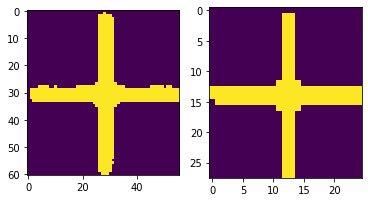

0.9508196721311475
28
26


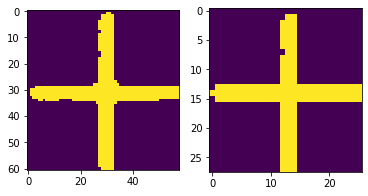

0.5441176470588235
28
15


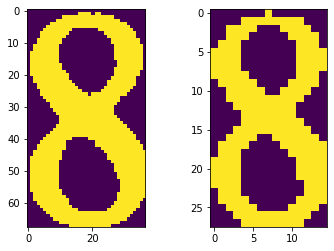

0.6615384615384615
28
18


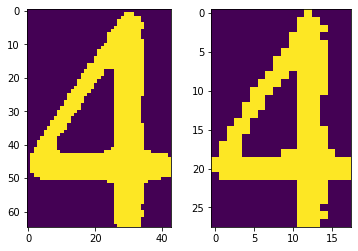

0.5846153846153846
28
16


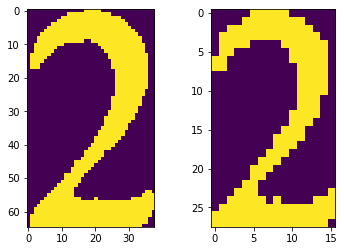

In [186]:
def resize_28x28(image):
    image_orig = image.copy()
    
    #important: preserve AR! -> resize dimension with higher size to 20, other will be <=20
    #ascpect ratio = width/height
    n_cols = image.shape[1]
    n_rows = image.shape[0]
    
    n_rows_new = 28
    n_cols_new = 28
    
    if (n_cols > n_rows):
        print("wider")
        ar = float(n_cols) / n_rows
        print(ar)
        n_rows_new = int(n_cols_new / ar)
        print(n_rows_new)
        print(n_cols_new)
    else:
        ar = float(n_cols) / n_rows
        print(ar)
        n_cols_new = int(n_rows_new * ar)
        print(n_rows_new)
        print(n_cols_new)
        
    image = cv.resize(image,(n_cols_new, n_rows_new))
    
    ret, image = cv.threshold(image, 200, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(image_orig)
    axes[1].imshow(image)
    plt.show()
    
    
    return image


#TO DO maybe interpolation method if zooming other if shrinking
figures_df['image'] = figures_df['image'].apply(resize_28x28)

now add black padding to get 28x28 pixels

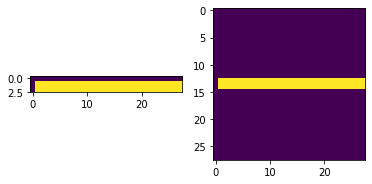

In [187]:
import math
def pad_fill(image, target_size, fill_value = 0):
    image_orig = image.copy()
    #image = cv.resize(image,(20,20))
    
    target_mat = np.full(
        shape=target_size,
        fill_value=fill_value,
        dtype=np.int)
    
    #TODO check if rectangular, or if /2 gives even number!!
    
    pad_x = (target_size[1] - image.shape[1]) / 2.0
    pad_y = (target_size[0] - image.shape[0]) / 2.0
    
    target_mat[math.floor(pad_y) : target_size[0] - math.ceil(pad_y),
               math.floor(pad_x) : target_size[1] - math.ceil(pad_x)] = image
    image = target_mat
    
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(image_orig)
    axes[1].imshow(image)
    plt.show()
    
    
    return image

#test
_ = pad_fill(figures_df.loc[0,'image'], (28,28), 0)

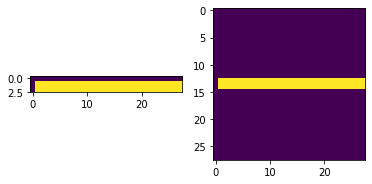

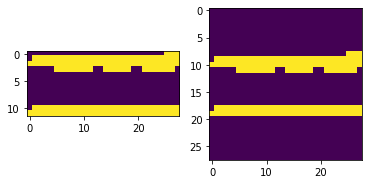

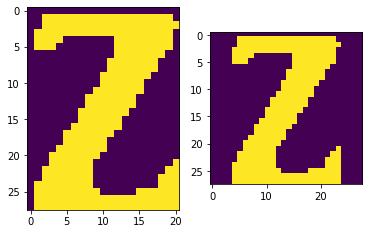

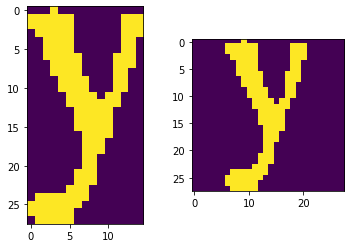

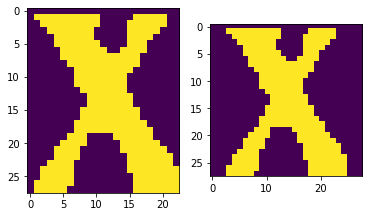

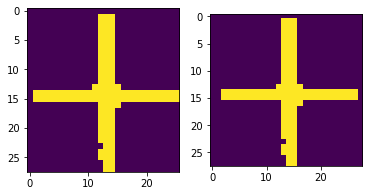

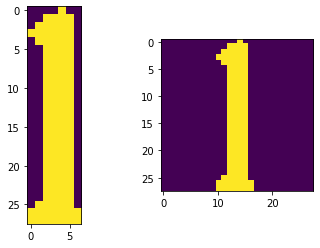

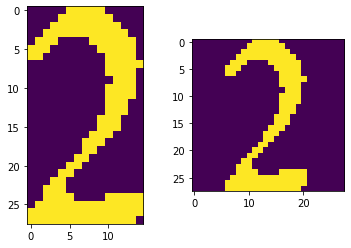

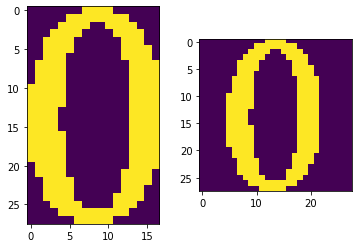

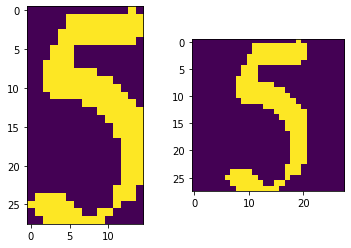

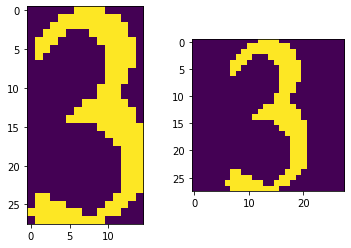

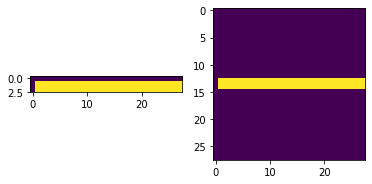

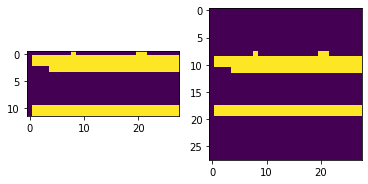

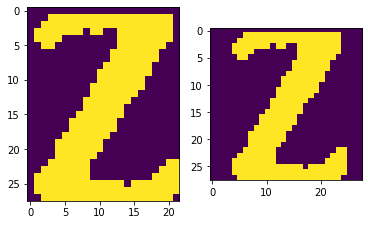

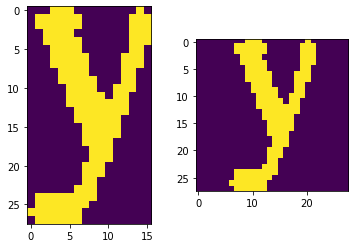

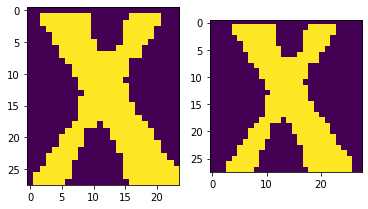

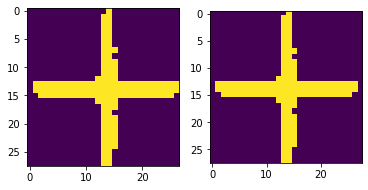

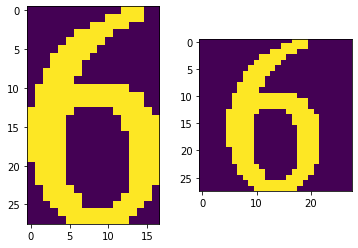

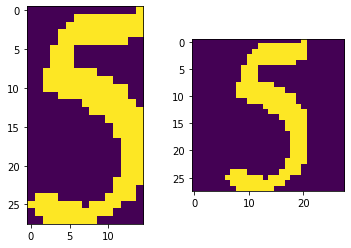

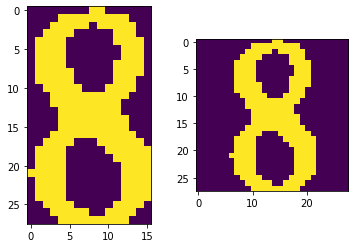

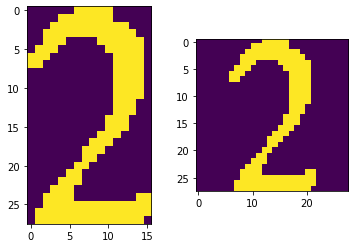

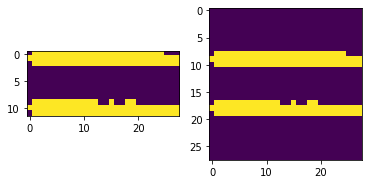

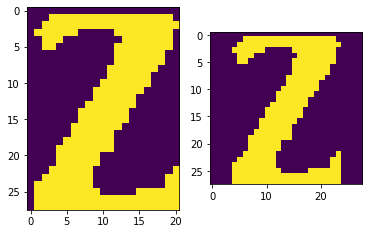

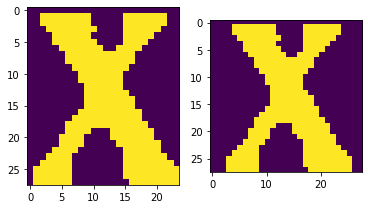

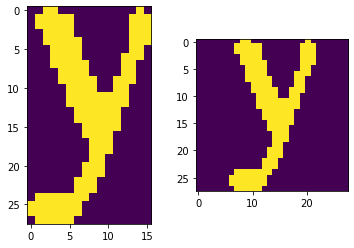

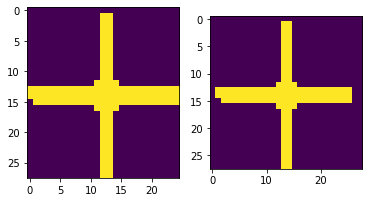

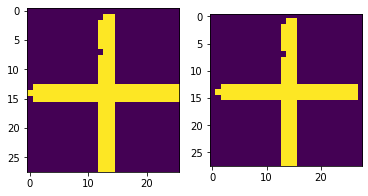

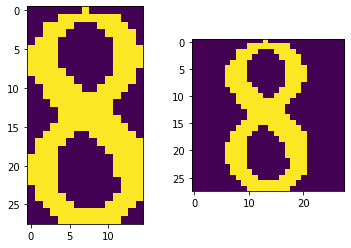

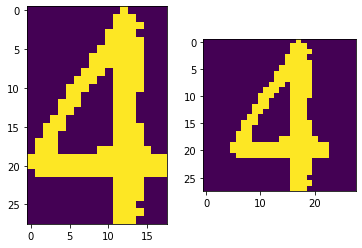

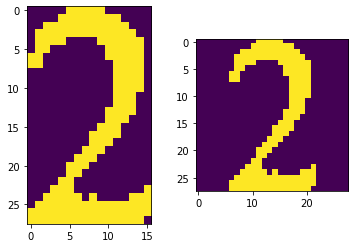

In [188]:
figures_df['image'] = figures_df['image'].apply(pad_fill, args = ((28,28), 0))

In [189]:
figures_df.head()

,line,position,image
0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, ..."
4,0,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [190]:
figures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   line      30 non-null     int64 
 1   position  30 non-null     int64 
 2   image     30 non-null     object
dtypes: int64(2), object(1)
memory usage: 848.0+ bytes


## Export images

import os
data_dir = './data'
filename = 'figures_df.csv'
figures_df.to_csv(os.path.join(data_dir, filename), index = False)

In [191]:
import os
from PIL import Image


directory = './data/scanned_images/example_1'
os.makedirs(directory, exist_ok = True)
def save_image_from_df(row, directory):
    print(row)
    image = Image.fromarray(row['image'])
    image = image.convert( 'RGB')
    print(image)
    image.save(os.path.join(directory, str(row['line']) + str(row['position']) + '.jpg'))
    
figures_df.apply(lambda row : save_image_from_df(row, directory), axis = 1)
    
    
    

line                                                        0
position                                                    0
image       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: 0, dtype: object
<PIL.Image.Image image mode=RGB size=28x28 at 0x21F1DA0A7F0>
line                                                        0
position                                                    1
image       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: 1, dtype: object
<PIL.Image.Image image mode=RGB size=28x28 at 0x21F1DA0A7F0>
line                                                        0
position                                                    2
image       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: 2, dtype: object
<PIL.Image.Image image mode=RGB size=28x28 at 0x21F1DA0A7F0>
line                                                        0
position                                                    3
image       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, ...
Name

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
dtype: object